In [1]:
import os
os.chdir('..')
from MPRA_predict.utils import *

In [2]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [3]:
MPRA_df = pd.read_csv('data/SirajMPRA/SirajMPRA_562654_0317.csv')
MPRA_df

,description,seq,A549,HepG2,K562,SK-N-SH,HCT116,is_ref,chr,pos,ref,alt,start,end,585605_index,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_CTCF
0,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.256,-1.092,0.156,-0.223,True,chr1,14677,G,A,14577,14777,0,1.313,1.923,1.661,1.207,1.434,2.131,1.846,1.459,1.430,2.004,1.373,1.165,1.121,2.139,1.727,1.287,0.923,2.057,1.624,1.192
1,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,-0.003,0.068,0.066,-0.719,False,chr1,14677,G,A,14577,14777,1,1.294,1.913,1.664,1.235,1.412,2.114,1.854,1.478,1.373,1.932,1.342,1.172,1.108,2.092,1.698,1.309,0.913,2.023,1.597,1.216
2,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,0.877,-0.803,0.354,0.821,True,chr1,63697,T,C,63597,63797,2,1.026,1.174,0.922,0.409,0.319,0.462,0.157,0.077,-0.110,1.248,1.787,0.427,1.392,1.204,0.838,0.314,0.907,0.570,0.795,0.221
3,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,0.756,-1.050,-0.154,0.766,False,chr1,63697,T,C,63597,63797,3,1.022,0.990,0.783,0.411,0.224,0.305,0.004,0.031,-0.260,0.935,1.525,0.331,1.384,0.969,0.632,0.298,0.922,0.446,0.676,0.203
4,chr1:64764:C:T,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.649,-0.449,0.119,-0.114,True,chr1,64764,C,T,64664,64864,4,-0.988,-0.719,-0.858,-0.901,-0.765,-0.781,-0.662,-0.702,-0.835,-0.535,-0.424,-0.759,-1.083,-0.813,-0.803,-0.821,-0.932,-0.819,-0.736,-0.672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562649,chrX:155233098:T:C,ATCATTTACTGGTGACTGCCCTGCTAGGGTGTCAGCTGTCAGATCC...,NaN,0.203,1.334,0.397,0.749,False,chrX,155233098,T,C,155232998,155233198,585600,2.066,2.190,2.592,1.500,1.432,1.429,1.501,1.072,1.033,0.962,0.688,1.042,1.518,2.014,2.117,1.190,1.163,1.556,1.322,0.957
562650,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,1.021,0.070,2.294,1.259,True,chrX,155233794,A,G,155233694,155233894,585601,0.844,1.232,0.820,0.878,0.668,0.696,0.611,0.360,1.408,1.956,2.360,1.108,1.744,1.473,1.525,0.911,1.850,1.703,1.653,0.852
562651,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,0.490,-0.510,1.487,0.482,False,chrX,155233794,A,G,155233694,155233894,585602,0.810,1.391,0.957,0.843,0.601,0.870,0.746,0.399,1.332,1.832,1.878,1.018,1.374,1.496,1.356,0.833,1.467,1.782,1.487,0.710
562652,chrX:155234730:T:C,TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...,NaN,-0.110,-0.290,-0.382,0.093,True,chrX,155234730,T,C,155234630,155234830,585603,0.332,0.238,0.301,0.369,0.197,0.448,0.404,0.015,0.536,-0.096,-0.573,0.347,0.942,0.194,-0.096,0.126,0.348,-0.175,-0.273,-0.135


In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(1, 23)])
data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(3, 23)])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])
data_split_dict['designed'] = MPRA_df['chr'].isin(['chr0'])


MPRA_df['std'] = MPRA_df[cell_types].std(axis=1, skipna=True)
std_threshold = np.percentile(MPRA_df['std'].dropna(), 95) # 95%分位数
data_split_dict['diff'] = (MPRA_df['std'] > std_threshold)
data_split_dict['const'] = ~data_split_dict['diff']




# MPRA_df['diff'] = (MPRA_df[cell_types].max(axis=1) - MPRA_df[cell_types].min(axis=1)) > 1
# data_split_dict['const'] = ~MPRA_df['diff']
# data_split_dict['diff']  = MPRA_df['diff']
print('const ', data_split_dict['const'].sum())
print('diff  ', data_split_dict['diff'].sum())


keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}_{k2}'] = data_split_dict[k1] & data_split_dict[k2]

const  534581
diff   28073


In [20]:
values = MPRA_df[cell_types].values

# partition 前两个最大值，忽略 NaN（负号用于找最大）
top2 = -np.nanpartition(-values, kth=1, axis=1)[:, :2]

# 求最大和次大（这两个值中最大的和最小的）
max_vals = np.nanmax(top2, axis=1)
second_max_vals = np.nanmin(top2, axis=1)

# 差值
MPRA_df['MinGap'] = max_vals - second_max_vals

AttributeError: module 'numpy' has no attribute 'nanpartition'

In [11]:
cell_types = ['K562', 'HepG2', 'SK-N-SH']
values = MPRA_df[cell_types].values
print((np.isnan(values)).any())

# 对每一行排序（从小到大），取出最大和次大
sorted_values = np.sort(values, axis=1)
largest = sorted_values[:, -1]
second_largest = sorted_values[:, -2]

# 计算最大值减去次大值
MPRA_df['MinGap'] = largest - second_largest

True


In [13]:
values.shape

(562654, 3)

In [18]:
print(MPRA_df[MPRA_df[cell_types].isna().any(axis=1)])

               description                                                seq  A549  HepG2   K562  SK-N-SH  HCT116  is_ref   chr        pos ref alt      start        end  585605_index  HepG2_DNase  HepG2_H3K4me3  HepG2_H3K27ac  HepG2_CTCF  K562_DNase  K562_H3K4me3  K562_H3K27ac  K562_CTCF  SK-N-SH_DNase  SK-N-SH_H3K4me3  SK-N-SH_H3K27ac  SK-N-SH_CTCF  A549_DNase  A549_H3K4me3  A549_H3K27ac  A549_CTCF  HCT116_DNase  HCT116_H3K4me3  HCT116_H3K27ac  HCT116_CTCF   std  MinGap  specificity_bin
366       chr1:1015126:A:G  TGTGGTCTCGGCGCCAGGCCAGGCCTCCCTGTGCAGGAGAGGAGCC...   NaN  1.249    NaN      NaN   1.802    True  chr1    1015126   A   G    1015026    1015226           385        3.200          3.287          3.259       2.049       3.112         2.797         2.719      2.346          4.158            3.534            4.283         2.827       2.514         3.249         3.527      2.140         2.968           3.437           3.476        2.062 0.391     NaN             <NA>
367       ch

In [19]:
print([(MPRA_df[cell_types].isna().sum(axis=1) == i).sum() for i in range(5)])

[557772, 2814, 2066, 2, 0]


In [ ]:
# 先提取指定细胞类型的子表
values = MPRA_df[cell_types].values

# 对每一行排序（从小到大），取出最大和次大
sorted_values = np.sort(values, axis=1)
largest = sorted_values[:, -1]
second_largest = sorted_values[:, -2]

# 计算最大值减去次大值
MPRA_df['MinGap'] = largest - second_largest

In [6]:
def assign_bin(value, bin_edges):
    """
    根据 bin_edges 的顺序，把 value 分到对应的区间：
    - 若 value <= bin_edges[0] 则返回 0
    - 若 bin_edges[0] < value <= bin_edges[1] 则返回 1
    - ...
    - 若 value > bin_edges[-1] 则返回 len(bin_edges)
    
    若 value 为 NaN 则返回 NaN
    """
    # 若是缺失值，直接返回 NaN
    if np.isnan(value):
        return np.nan
    
    # 依次比较 value 与每个阈值
    for i, edge in enumerate(bin_edges):
        if value <= edge:
            return i
    
    # 若都不符合，value 在最后一个区间
    return len(bin_edges)

In [9]:
# # 计算分位数

# # percentile_bins = np.percentile(MPRA_df['std'].dropna(), [20, 40, 60, 80])
# # percentile_bins = np.percentile(MPRA_df['std'].dropna(), [60, 80, 90, 95])
# percentile_bins = [0.4, 0.8, 1.2]


# MPRA_df['specificity_bin'] = (
#     MPRA_df['std']
#     .apply(lambda x: assign_bin(x, percentile_bins))
#     .astype("Int64")  # 支持nan
# )

# print(MPRA_df['specificity_bin'].value_counts().sort_index())




# 计算分位数

# percentile_bins = np.percentile(MPRA_df['std'].dropna(), [20, 40, 60, 80])
# percentile_bins = np.percentile(MPRA_df['std'].dropna(), [60, 80, 90, 95])
percentile_bins = [0.4, 0.8, 1.2]


MPRA_df['specificity_bin'] = (
    MPRA_df['MinGap']
    .apply(lambda x: assign_bin(x, percentile_bins))
    .astype("Int64")  # 支持nan
)

print(MPRA_df['specificity_bin'].value_counts().sort_index())

specificity_bin
0    10561
1     2440
2      718
3      547
Name: count, dtype: Int64


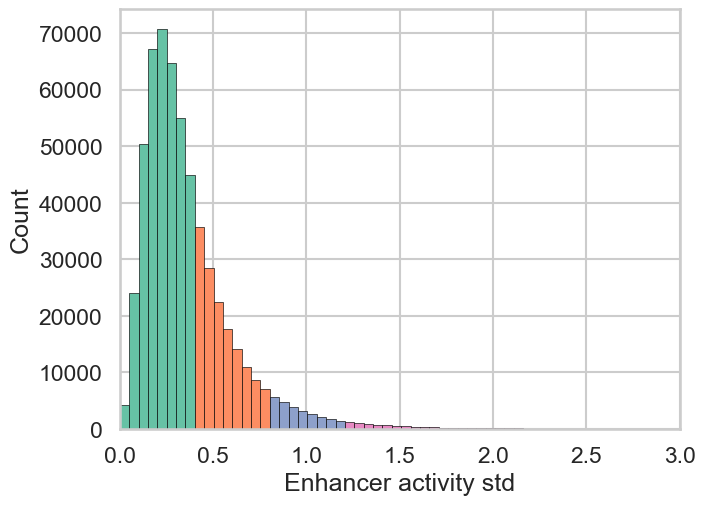

In [25]:
bin_edges = [MPRA_df['std'].min()] + list(percentile_bins) + [MPRA_df['std'].max()]

# 创建直方图
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

ax = sns.histplot(MPRA_df['std'], binwidth=0.05, edgecolor='black')

# 给每个 patch 着色
for patch in ax.patches:
    center = patch.get_x() + patch.get_width() / 2
    # 根据中心值落在哪个 bin，设置颜色
    for i in range(5):
        if bin_edges[i] <= center < bin_edges[i+1]:
            patch.set_facecolor(color_list[i])
            break

plt.xlim(0, 3)
plt.xlabel('Enhancer activity std')
plt.ylabel('Count')
plt.savefig('predict_enhancer_activity/figures/hist_enhancer_activity_std.png', dpi=400)
plt.show()


In [27]:
# 各细胞类型的真实活性的相关性

for bin in range(4):
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types, dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = (MPRA_df['specificity_bin'] == bin)
            df = MPRA_df[condition]
            x, y = df[f'{cell_type}'], df[f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_2] = r
    print(f'{bin=}')
    print(corr_matrix)
    print()

bin=0
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.860    0.865 0.806   0.898
K562     0.860 1.000    0.822 0.803   0.856
SK-N-SH  0.865 0.822    1.000 0.789   0.849
A549     0.806 0.803    0.789 1.000   0.800
HCT116   0.898 0.856    0.849 0.800   1.000

bin=1
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.795    0.827 0.716   0.863
K562     0.795 1.000    0.733 0.695   0.806
SK-N-SH  0.827 0.733    1.000 0.718   0.788
A549     0.716 0.695    0.718 1.000   0.752
HCT116   0.863 0.806    0.788 0.752   1.000

bin=2
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.594    0.729 0.685   0.748
K562     0.594 1.000    0.546 0.626   0.641
SK-N-SH  0.729 0.546    1.000 0.753   0.700
A549     0.685 0.626    0.753 1.000   0.773
HCT116   0.748 0.641    0.700 0.773   1.000

bin=3
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.227    0.488 0.564   0.521
K562     0.227 1.000    0.262 0.422   0.276
SK-N-SH  0.488 0.262    1.000 0.782   0.602
A549 

In [6]:
corr_matrix_list_dict = {}
for data_split in ['total', 'train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix_list_dict[data_split] = []

In [7]:
# 真实活性和DNase的相关性

for data_split in ['total', 'train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types, dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x, y = df[f'{cell_type}'], df[f'{cell_type_2}_DNase']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_2] = r
    print(data_split)
    print(corr_matrix)
    # plt.figure(figsize=(8, 6), dpi=100)
    # plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
    # sns.heatmap(
    #     corr_matrix, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
    #     annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    # plt.xticks(
    #     ticks=np.arange(len(cell_types))+0.5, labels=cell_types, 
    #     rotation=0, fontsize=14)
    # plt.yticks(
    #     ticks=np.arange(len(cell_types))+0.5, labels=cell_types, 
    #     rotation=0, fontsize=14)
    # # plt.title(f'Pearson r between cell types', fontsize=20)
    # # plt.savefig(f'predict_enhancer_activity/figures/heatmap_pearson_r_{data_split}_activity_vs_activity.png', dpi=400)
    # plt.show()

total
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    0.443 0.483    0.398 0.435   0.444
K562     0.353 0.499    0.357 0.382   0.404
SK-N-SH  0.336 0.425    0.368 0.370   0.378
A549     0.297 0.364    0.273 0.348   0.367
HCT116   0.368 0.427    0.364 0.389   0.424
train
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    0.445 0.486    0.401 0.437   0.446
K562     0.355 0.502    0.360 0.384   0.406
SK-N-SH  0.339 0.428    0.370 0.372   0.381
A549     0.299 0.366    0.274 0.349   0.369
HCT116   0.369 0.429    0.366 0.390   0.425
valid
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    0.435 0.475    0.390 0.427   0.437
K562     0.341 0.489    0.347 0.371   0.394
SK-N-SH  0.329 0.421    0.366 0.367   0.376
A549     0.291 0.365    0.272 0.350   0.366
HCT116   0.365 0.426    0.360 0.389   0.426
test
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    0.426 0.450    0.370 0.416   0.418
K562     0.336 0.474    0.337 0.364   0.382
SK-N-SH  0.308 0.391    0.339 0.339   0.349
A549     

In [15]:
# 各细胞类型的真实活性的相关性

for data_split in ['total', 'train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types, dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x, y = df[f'{cell_type}'], df[f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_2] = r
    print(data_split)
    print(corr_matrix)
    print()
    # plt.figure(figsize=(8, 6), dpi=100)
    # plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
    # sns.heatmap(
    #     corr_matrix, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
    #     annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    # plt.xticks(
    #     ticks=np.arange(len(cell_types))+0.5, labels=cell_types, 
    #     rotation=0, fontsize=14)
    # plt.yticks(
    #     ticks=np.arange(len(cell_types))+0.5, labels=cell_types, 
    #     rotation=0, fontsize=14)
    # plt.title(f'Pearson r between cell types', fontsize=20)
    # plt.savefig(f'predict_enhancer_activity/figures/heatmap_pearson_r_{data_split}_activity_vs_activity.png', dpi=400)
    # plt.show()

total
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.786    0.826 0.738   0.867
K562     0.786 1.000    0.738 0.727   0.808
SK-N-SH  0.826 0.738    1.000 0.778   0.815
A549     0.738 0.727    0.778 1.000   0.815
HCT116   0.867 0.808    0.815 0.815   1.000

train
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.788    0.827 0.740   0.868
K562     0.788 1.000    0.739 0.728   0.808
SK-N-SH  0.827 0.739    1.000 0.778   0.816
A549     0.740 0.728    0.778 1.000   0.817
HCT116   0.868 0.808    0.816 0.817   1.000

valid
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.778    0.821 0.739   0.859
K562     0.778 1.000    0.735 0.735   0.805
SK-N-SH  0.821 0.735    1.000 0.784   0.811
A549     0.739 0.735    0.784 1.000   0.804
HCT116   0.859 0.805    0.811 0.804   1.000

test
         HepG2  K562  SK-N-SH  A549  HCT116
HepG2    1.000 0.770    0.806 0.727   0.858
K562     0.770 1.000    0.726 0.708   0.802
SK-N-SH  0.806 0.726    1.000 0.769   0.802
A549  

In [10]:
# # seq one model per cell type

# HepG2_pred = np.load(f'saved/0311_SirajMPRA_1_cell_type_HepG2/0311_174938/test_pred.npy')
# K562_pred = np.load(f'saved/0311_SirajMPRA_1_cell_type_K562/0311_180527/test_pred.npy')
# SKNSH_pred = np.load(f'saved/0311_SirajMPRA_1_cell_type_SK-N-SH/0311_201338/test_pred.npy')
# A549_pred = np.load(f'saved/0311_SirajMPRA_1_cell_type_A549/0311_231044/test_pred.npy')
# HCT116_pred = np.load(f'saved/0311_SirajMPRA_1_cell_type_HCT116/0312_010235/test_pred.npy')

# y_pred = np.concatenate([HepG2_pred, K562_pred, SKNSH_pred, A549_pred, HCT116_pred], axis=1)

# cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
# MPRA_df[cell_types_pred] = y_pred

In [11]:
# # 预测值彼此的相关性

# for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
#     cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
#     corr_matrix = pd.DataFrame(index=cell_types_pred, columns=cell_types_pred)
#     for cell_type in cell_types:
#         for cell_type_2 in cell_types:
#             condition = data_split_dict[data_split]
#             df = MPRA_df[condition]
#             x = df[f'{cell_type}_pred']
#             y = df[f'{cell_type_2}_pred']
#             r, p = pearson(x, y)
#             corr_matrix.loc[f'{cell_type}_pred', f'{cell_type_2}_pred'] = r
#     print(data_split)
#     print(corr_matrix)

In [12]:
# seq
# train 5 cell types

y_pred = np.load(f'saved/0304_SirajMPRA_seq/0304_033552/test_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [13]:
# 预测值彼此的相关性

for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
    corr_matrix = pd.DataFrame(index=cell_types_pred, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}_pred']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_matrix.loc[f'{cell_type}_pred', f'{cell_type_2}_pred'] = r
    print(data_split)
    print(corr_matrix)

train
             HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2_pred        1.000     0.890        0.930     0.890       0.944
K562_pred         0.890     1.000        0.854     0.884       0.905
SK-N-SH_pred      0.930     0.854        1.000     0.927       0.907
A549_pred         0.890     0.884        0.927     1.000       0.902
HCT116_pred       0.944     0.905        0.907     0.902       1.000
valid
             HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2_pred        1.000     0.880        0.918     0.865       0.934
K562_pred         0.880     1.000        0.836     0.880       0.893
SK-N-SH_pred      0.918     0.836        1.000     0.908       0.885
A549_pred         0.865     0.880        0.908     1.000       0.885
HCT116_pred       0.934     0.893        0.885     0.885       1.000
test
             HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2_pred        1.000     0.877        0.915     0.866       0.932
K562_pred        

In [14]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(corr_matrix)

train
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.927     0.811        0.850     0.809       0.864
K562         0.824     0.932        0.785     0.811       0.835
SK-N-SH      0.852     0.773        0.921     0.841       0.826
A549         0.783     0.757        0.811     0.889       0.785
HCT116       0.877     0.838        0.838     0.833       0.931
valid
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.842     0.730        0.765     0.720       0.777
K562         0.754     0.849        0.714     0.748       0.760
SK-N-SH      0.775     0.695        0.840     0.754       0.739
A549         0.713     0.692        0.733     0.804       0.708
HCT116       0.795     0.758        0.751     0.756       0.850
test
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.839     0.723        0.760     0.717       0.769
K562         0.747     0.844        0.711     0.737       0.752
SK-N-SH      0.760     

In [11]:
# seq + feature
# train 5 cell types

y_pred = np.load(f'saved/0305_SirajMPRA_seq_feature_matrix/0304_033430/test_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [41]:
# 预测值彼此的相关性

for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
    corr_matrix = pd.DataFrame(index=cell_types_pred, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}_pred']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_matrix.loc[f'{cell_type}_pred', f'{cell_type_2}_pred'] = r
    print(data_split)
    print(corr_matrix)

train
             HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2_pred        1.000     0.978        0.962     0.983       0.978
K562_pred         0.978     1.000        0.965     0.978       0.978
SK-N-SH_pred      0.962     0.965        1.000     0.979       0.975
A549_pred         0.983     0.978        0.979     1.000       0.991
HCT116_pred       0.978     0.978        0.975     0.991       1.000
valid
             HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2_pred        1.000     0.972        0.953     0.979       0.972
K562_pred         0.972     1.000        0.957     0.973       0.973
SK-N-SH_pred      0.953     0.957        1.000     0.973       0.969
A549_pred         0.979     0.973        0.973     1.000       0.989
HCT116_pred       0.972     0.973        0.969     0.989       1.000
test
             HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2_pred        1.000     0.971        0.946     0.977       0.969
K562_pred        

In [12]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(corr_matrix)

train
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.901     0.875        0.864     0.882       0.879
K562         0.838     0.871        0.827     0.843       0.843
SK-N-SH      0.868     0.868        0.889     0.878       0.875
A549         0.835     0.835        0.836     0.864       0.857
HCT116       0.890     0.879        0.874     0.894       0.900
valid
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.824     0.801        0.786     0.807       0.805
K562         0.768     0.808        0.759     0.778       0.780
SK-N-SH      0.787     0.792        0.812     0.801       0.799
A549         0.738     0.745        0.741     0.771       0.767
HCT116       0.808     0.800        0.794     0.818       0.826
test
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.817     0.789        0.776     0.800       0.796
K562         0.759     0.798        0.752     0.769       0.772
SK-N-SH      0.770     

In [15]:
# seq + feature
# train 3 cell types (HepG2, K562, SKNSH), valid 2 cell types (A549 HCT116)

y_pred = np.load(f'saved/0307_SirajMPRA_3_cell_types/0307_065629/test_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [16]:
for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            x, y = remove_nan(x, y)
            r, p = pearsonr(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(corr_matrix)

train
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.901     0.866        0.861     0.878       0.872
K562         0.842     0.878        0.833     0.845       0.846
SK-N-SH      0.865     0.860        0.893     0.873       0.869
A549         0.789     0.788        0.796     0.821       0.815
HCT116       0.858     0.841        0.842     0.858       0.864
valid
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.820     0.787        0.779     0.797       0.793
K562         0.767     0.810        0.760     0.777       0.778
SK-N-SH      0.784     0.785        0.818     0.798       0.794
A549         0.727     0.733        0.733     0.761       0.758
HCT116       0.784     0.772        0.771     0.793       0.802
test
        HepG2_pred K562_pred SK-N-SH_pred A549_pred HCT116_pred
HepG2        0.818     0.781        0.774     0.797       0.790
K562         0.758     0.802        0.755     0.768       0.772
SK-N-SH      0.768     

In [25]:
# # seq + feature
# # train 4 cell types, valid 1 cell type, leave-one-out

# y_pred = np.zeros((len(MPRA_df), 5))
# y_pred[:, 0] = np.load(f'saved/0306_SirajMPRA_seq_feature_without_HepG2/0306_041237/test_pred.npy')[:, 0]
# y_pred[:, 1] = np.load(f'saved/0306_SirajMPRA_seq_feature_without_K562/0306_050958/test_pred.npy')[:, 1]
# y_pred[:, 2] = np.load(f'saved/0306_SirajMPRA_seq_feature_without_SK-N-SH/0306_061734/test_pred.npy')[:, 2]
# y_pred[:, 3] = np.load(f'saved/0306_SirajMPRA_seq_feature_without_A549/0307_010836/test_pred.npy')[:, 3]
# y_pred[:, 4] = np.load(f'saved/0306_SirajMPRA_seq_feature_without_HCT116/0306_080925/test_pred.npy')[:, 4]

# cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
# MPRA_df[cell_types_pred] = y_pred




y_pred = np.zeros((len(MPRA_df), 5))
y_pred[:, 0] = np.load(f'saved/0317_SirajMPRA_four_cell_type_without_HepG2/0316_141323/test_pred.npy')[:, 0]
y_pred[:, 1] = np.load(f'saved/0317_SirajMPRA_four_cell_type_without_K562/0316_163929/test_pred.npy')[:, 1]
y_pred[:, 2] = np.load(f'saved/0317_SirajMPRA_four_cell_type_without_SK-N-SH/0316_182022/test_pred.npy')[:, 2]
y_pred[:, 3] = np.load(f'saved/0317_SirajMPRA_four_cell_type_without_A549/0316_194504/test_pred.npy')[:, 3]
y_pred[:, 4] = np.load(f'saved/0317_SirajMPRA_four_cell_type_without_HCT116/0316_211026/test_pred.npy')[:, 4]

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

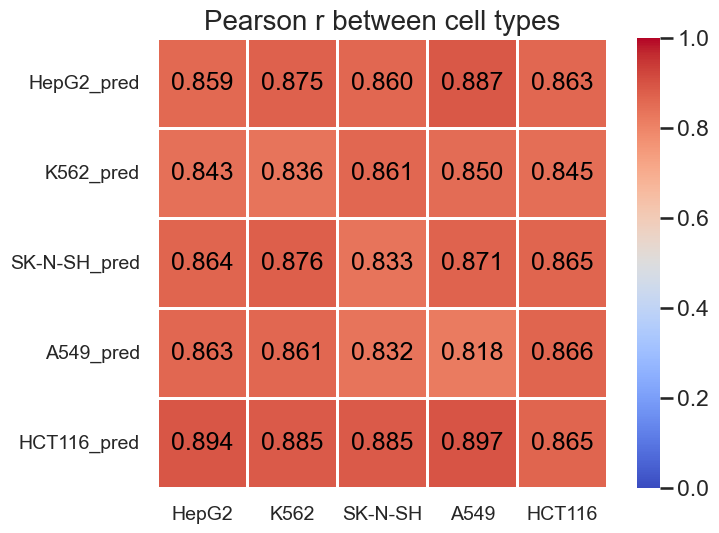

train
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.859      0.875         0.860      0.887        0.863
K562          0.843      0.836         0.861      0.850        0.845
SK-N-SH       0.864      0.876         0.833      0.871        0.865
A549          0.863      0.861         0.832      0.818        0.866
HCT116        0.894      0.885         0.885      0.897        0.865


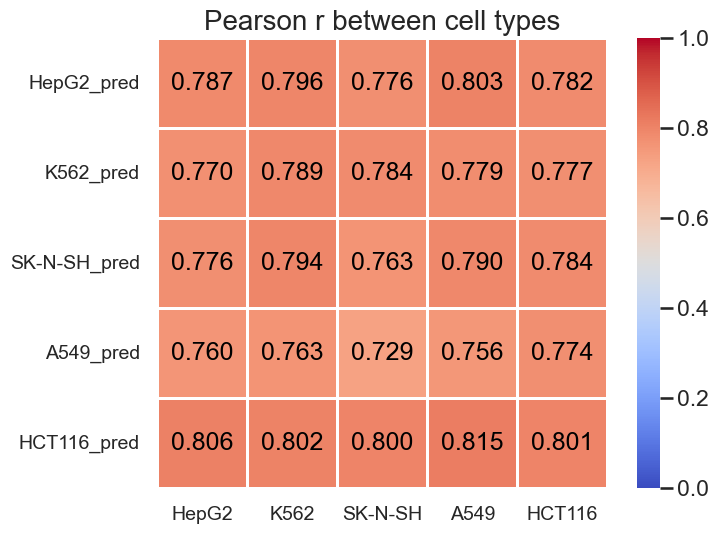

valid
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.787      0.796         0.776      0.803        0.782
K562          0.770      0.789         0.784      0.779        0.777
SK-N-SH       0.776      0.794         0.763      0.790        0.784
A549          0.760      0.763         0.729      0.756        0.774
HCT116        0.806      0.802         0.800      0.815        0.801


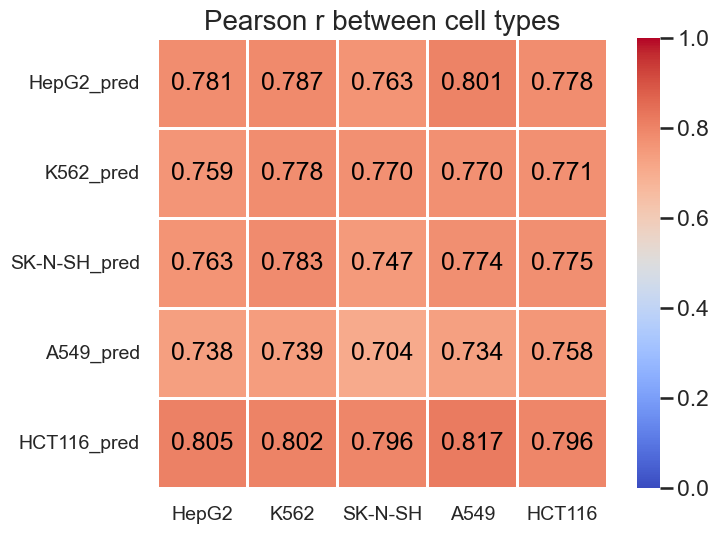

test
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.781      0.787         0.763      0.801        0.778
K562          0.759      0.778         0.770      0.770        0.771
SK-N-SH       0.763      0.783         0.747      0.774        0.775
A549          0.738      0.739         0.704      0.734        0.758
HCT116        0.805      0.802         0.796      0.817        0.796


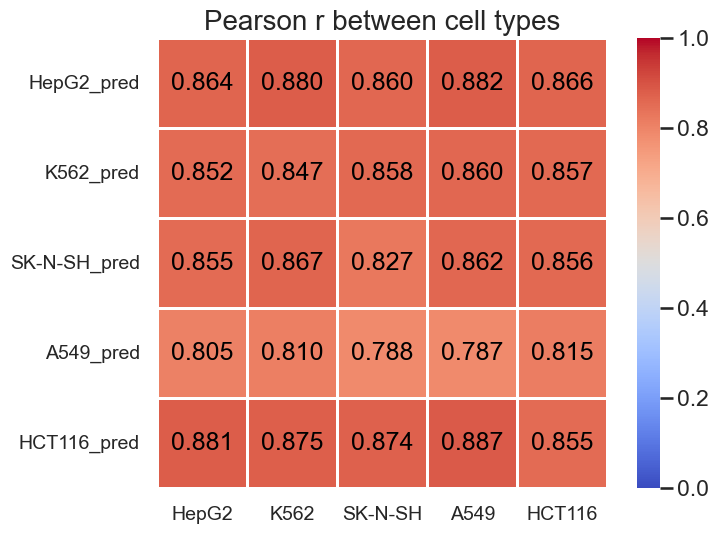

const
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.864      0.880         0.860      0.882        0.866
K562          0.852      0.847         0.858      0.860        0.857
SK-N-SH       0.855      0.867         0.827      0.862        0.856
A549          0.805      0.810         0.788      0.787        0.815
HCT116        0.881      0.875         0.874      0.887        0.855


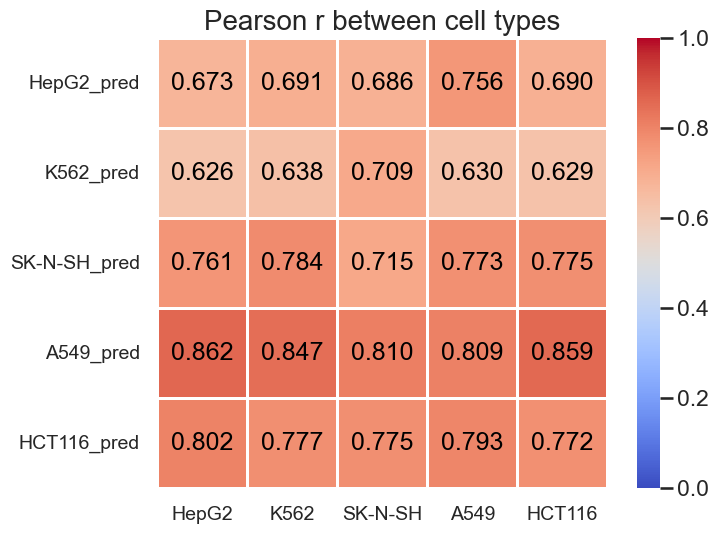

diff
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.673      0.691         0.686      0.756        0.690
K562          0.626      0.638         0.709      0.630        0.629
SK-N-SH       0.761      0.784         0.715      0.773        0.775
A549          0.862      0.847         0.810      0.809        0.859
HCT116        0.802      0.777         0.775      0.793        0.772


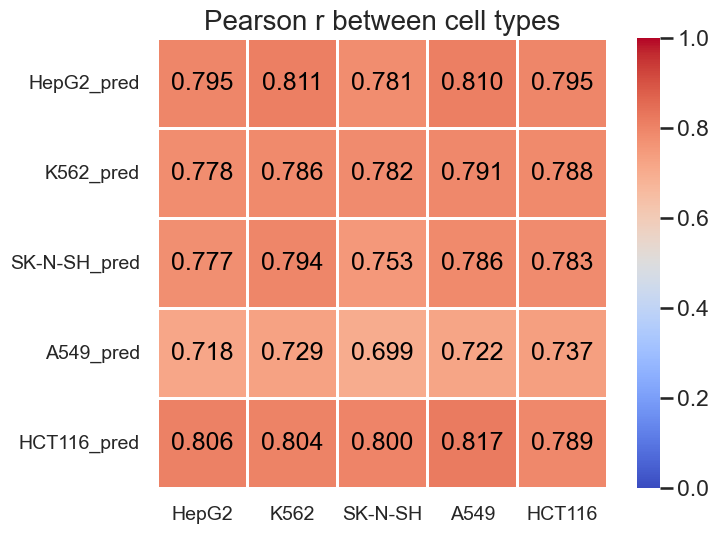

test_const
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.795      0.811         0.781      0.810        0.795
K562          0.778      0.786         0.782      0.791        0.788
SK-N-SH       0.777      0.794         0.753      0.786        0.783
A549          0.718      0.729         0.699      0.722        0.737
HCT116        0.806      0.804         0.800      0.817        0.789


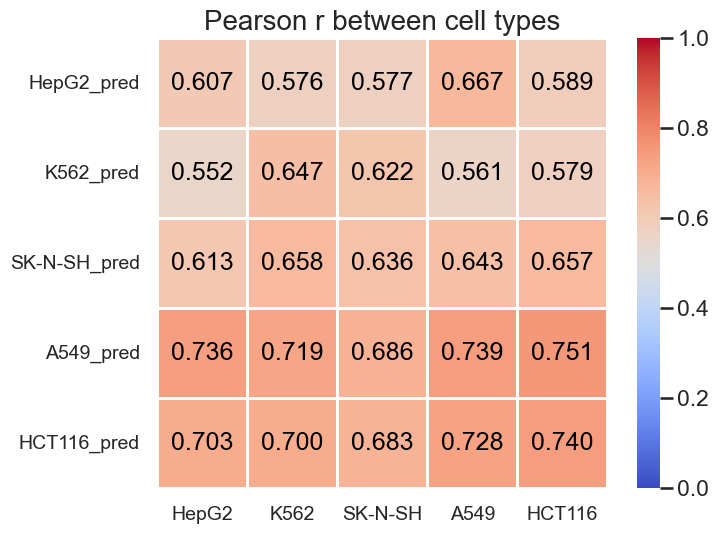

test_diff
         HepG2_pred  K562_pred  SK-N-SH_pred  A549_pred  HCT116_pred
HepG2         0.607      0.576         0.577      0.667        0.589
K562          0.552      0.647         0.622      0.561        0.579
SK-N-SH       0.613      0.658         0.636      0.643        0.657
A549          0.736      0.719         0.686      0.739        0.751
HCT116        0.703      0.700         0.683      0.728        0.740


In [26]:
for data_split in ['train', 'valid', 'test', 'const', 'diff', 'test_const', 'test_diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred, dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = np.array(df[f'{cell_type}'])
            y = np.array(df[f'{cell_type_2}_pred'])
            x, y = remove_nan(x, y)
            r, p = pearsonr(x, y)
            corr_matrix.loc[cell_type, f'{cell_type_2}_pred'] = r

    plt.figure(figsize=(8, 6), dpi=100)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
    sns.heatmap(
        corr_matrix, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
        annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    plt.xticks(
        ticks=np.arange(len(cell_types))+0.5, labels=cell_types, 
        rotation=0, fontsize=14)
    plt.yticks(
        ticks=np.arange(len(cell_types))+0.5, labels=cell_types_pred, 
        rotation=0, fontsize=14)
    plt.title(f'Pearson r between cell types', fontsize=20)
    plt.savefig(f'predict_enhancer_activity/figures/heatmap_pearson_r_{data_split}_seq_feature_pred_vs_activity.png', dpi=400)
    plt.show()
    print(data_split)
    print(corr_matrix)

In [23]:
y_pred_4_0 = np.load(f'saved/0812_SirajMPRA_seq_celltype4/0814_053219/test_pred.npy')
print(y_pred_4_0.shape)

y_pred_4_f = np.load(f'saved/0812_SirajMPRA_seq_feature_celltype4/0815_041254/test_pred.npy')
print(y_pred_4_f.shape)

y_pred_3_H = np.load(f'saved/0815_SirajMPRA_seq_feature_celltype3/0815_041826/test_pred.npy')
print(y_pred_3_H.shape)

y_pred_3_A = np.load(f'saved/0815_SirajMPRA_seq_feature_celltype3/0819_005952/test_pred.npy')
print(y_pred_3_A.shape)

y_pred_3_K = np.load(f'saved/0815_SirajMPRA_seq_feature_celltype3/0815_214824/test_pred.npy')
print(y_pred_3_K.shape)

y_pred_3_H = np.load(f'saved/0815_SirajMPRA_seq_feature_celltype3/0815_214850/test_pred.npy')
print(y_pred_3_H.shape)

(585605, 4)
(1765218,)
(1765218,)
(1765218,)
(1765218,)
(1765218,)


In [25]:
MPRA_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/SirajMPRA/SirajMPRA_total.csv')
# print(MPRA_df.head())

df2 = pd.read_csv('/home/hxcai/cell_type_specific_CRE/MPRA_exp/pretrained_based_models/data/Sei_Siraj_features_concat.csv')
# print(df2.head())


# 下面二选一

for i, cell_type in enumerate(['K562', 'HepG2', 'A549', 'HCT116']):
    MPRA_df[f'{cell_type}_pred'] = y_pred_4_0[:, i]
MPRA_df


# df2['pred'] = y_pred_4_0
# for i, cell_type in enumerate(['K562', 'HepG2', 'A549', 'HCT116']):
#     df = df2[df2['cell_type'] == cell_type][['seq', 'pred']]
#     df.rename(columns={'pred': f'{cell_type}_pred'}, inplace=True)
#     df = df.drop_duplicates(subset=['seq'])
#     MPRA_df = pd.merge(MPRA_df, df, on='seq', how='left')
# MPRA_df

,seq,A549,HepG2,K562,SKNSH,HCT116,is_ref,chr,pos,ref,alt,HepG2_pred,K562_pred,A549_pred,HCT116_pred
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.667516,-0.704147,0.538641,0.159069,True,chr1,14677,G,A,0.860727,0.471197,0.197887,0.369649
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.415984,0.554099,0.441904,-0.288019,False,chr1,14677,G,A,0.745834,0.418501,0.144777,0.290741
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.269937,-0.391222,0.752052,1.100437,True,chr1,63697,T,C,0.044020,-0.045745,-0.043967,-0.115304
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.151995,-0.659023,0.204721,1.050619,False,chr1,63697,T,C,0.009691,-0.069309,-0.071219,-0.152117
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.211076,-0.007174,0.499376,0.257572,True,chr1,64764,C,T,-0.129289,-0.136357,-0.108981,-0.104691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585600,ATCATTTACTGGTGACTGCCCTGCTAGGGTGTCAGCTGTCAGATCC...,NaN,0.615976,1.927090,0.798263,1.035440,False,chrX,155233098,T,C,-0.130473,0.371278,-0.105545,-0.168190
585601,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,1.409758,0.556338,2.843295,1.495515,True,chrX,155233794,A,G,1.410156,0.740903,0.845696,0.935793
585602,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,0.894634,-0.072647,1.973661,0.794848,False,chrX,155233794,A,G,1.131462,0.488258,0.668862,0.834238
585603,TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...,NaN,0.312172,0.165634,-0.041383,0.444472,True,chrX,155234730,T,C,0.393603,0.419445,0.133474,0.314708


In [26]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(1, 23)])
data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(3, 23)])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])
data_split_dict['designed'] = MPRA_df['chr'].isin(['chr0'])


cell_types = ['K562', 'HepG2', 'A549', 'HCT116']
MPRA_df['diff'] = (MPRA_df[cell_types].max(axis=1) - MPRA_df[cell_types].min(axis=1)) > 1
data_split_dict['const'] = ~MPRA_df['diff']
data_split_dict['diff']  = MPRA_df['diff']
print(len(MPRA_df), data_split_dict['const'].sum(), data_split_dict['diff'].sum())


# MPRA_df['mean'] = MPRA_df[cell_types].mean(axis=1)
# MPRA_df['std'] = MPRA_df[cell_types].std(axis=1)

# threshold = MPRA_df['std'].quantile(0.2)
# data_split_dict['diff'] = (MPRA_df['std'] >= threshold)
# data_split_dict['const'] = (MPRA_df['std'] < threshold)

# print(data_split_dict['diff'].sum(), data_split_dict['const'].sum())

# # for cell_type in cell_types:
# #     # MPRA_df[f'{cell_type}_zscore'] = (MPRA_df[cell_type] - MPRA_df['mean']) / MPRA_df['std']
# #     # MPRA_df[f'{cell_type}_diff'] = MPRA_df[f'{cell_type}_zscore'].abs() > 1
# #     MPRA_df[f'{cell_type}_diff'] = (MPRA_df[cell_type] - MPRA_df['mean']).abs() > 1
# #     MPRA_df[f'{cell_type}_const'] = ~MPRA_df[f'{cell_type}_diff']
# #     print(f"{cell_type}_diff num = {MPRA_df[f'{cell_type}_diff'].sum()}")

In [28]:
cell_types = ['K562', 'HepG2', 'A549', 'HCT116']

for cell_type in cell_types:
    for cell_type_pred in cell_types:
        for data_split in ['total', 'train', 'valid', 'test', 'const', 'diff']:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            r = pearson(df[f'{cell_type}'], df[f'{cell_type_pred}'])
            print(f'{cell_type:6} true vs {cell_type_pred:6} true, {data_split:5}, pearson r = {r:.3f}')
        print()

HepG2  true vs HepG2  true, total, pearson r = 1.000
HepG2  true vs HepG2  true, train, pearson r = 1.000


HepG2  true vs HepG2  true, valid, pearson r = 1.000
HepG2  true vs HepG2  true, test , pearson r = 1.000
HepG2  true vs HepG2  true, const, pearson r = 1.000
HepG2  true vs HepG2  true, diff , pearson r = 1.000

HepG2  true vs K562   true, total, pearson r = 0.787
HepG2  true vs K562   true, train, pearson r = 0.789
HepG2  true vs K562   true, valid, pearson r = 0.779
HepG2  true vs K562   true, test , pearson r = 0.770
HepG2  true vs K562   true, const, pearson r = 0.833
HepG2  true vs K562   true, diff , pearson r = 0.651

HepG2  true vs A549   true, total, pearson r = 0.738
HepG2  true vs A549   true, train, pearson r = 0.740
HepG2  true vs A549   true, valid, pearson r = 0.737
HepG2  true vs A549   true, test , pearson r = 0.724
HepG2  true vs A549   true, const, pearson r = 0.705
HepG2  true vs A549   true, diff , pearson r = 0.656

HepG2  true vs HCT116 true, total, pearson r = 0.867
HepG2  true vs HCT116 true, train, pearson r = 0.869
HepG2  true vs HCT116 true, valid, pearson 

In [29]:
cell_types = ['K562', 'HepG2', 'A549', 'HCT116']

for cell_type in cell_types:
    for cell_type_pred in [cell_type]:
        for data_split in ['total', 'train', 'valid', 'test', 'const', 'diff']:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            r = pearson(df[f'{cell_type}'], df[f'{cell_type_pred}_pred'])
            print(f'{cell_type} true vs {cell_type_pred} pred, {data_split}, pearson r = {r:.3f}')
        print()

HepG2 true vs HepG2 pred, total, pearson r = 0.895
HepG2 true vs HepG2 pred, train, pearson r = 0.911
HepG2 true vs HepG2 pred, valid, pearson r = 0.813
HepG2 true vs HepG2 pred, test, pearson r = 0.811
HepG2 true vs HepG2 pred, const, pearson r = 0.858
HepG2 true vs HepG2 pred, diff, pearson r = 0.881

K562 true vs K562 pred, total, pearson r = 0.905
K562 true vs K562 pred, train, pearson r = 0.922
K562 true vs K562 pred, valid, pearson r = 0.823
K562 true vs K562 pred, test, pearson r = 0.816
K562 true vs K562 pred, const, pearson r = 0.849
K562 true vs K562 pred, diff, pearson r = 0.898

A549 true vs A549 pred, total, pearson r = 0.847
A549 true vs A549 pred, train, pearson r = 0.864
A549 true vs A549 pred, valid, pearson r = 0.767
A549 true vs A549 pred, test, pearson r = 0.760
A549 true vs A549 pred, const, pearson r = 0.728
A549 true vs A549 pred, diff, pearson r = 0.856

HCT116 true vs HCT116 pred, total, pearson r = 0.901
HCT116 true vs HCT116 pred, train, pearson r = 0.918
HCT

In [30]:
cell_types = ['K562', 'HepG2', 'A549', 'HCT116']

for cell_type in cell_types:
    for cell_type_pred in [cell_type]:
        for data_split in ['test']:
            for data_split_2 in ['total', 'const', 'diff']:
                condition = data_split_dict[data_split] & data_split_dict[data_split_2]
                df = MPRA_df[condition]
                r = pearson(df[f'{cell_type}'], df[f'{cell_type_pred}_pred'])
                print(f'{cell_type:6} true vs {cell_type_pred:6} pred, {data_split:5}, {data_split_2:4}, pearson r = {r:.3f}')
        print()

HepG2  true vs HepG2  pred, test , total, pearson r = 0.811
HepG2  true vs HepG2  pred, test , const, pearson r = 0.768
HepG2  true vs HepG2  pred, test , diff, pearson r = 0.783

K562   true vs K562   pred, test , total, pearson r = 0.816
K562   true vs K562   pred, test , const, pearson r = 0.749
K562   true vs K562   pred, test , diff, pearson r = 0.791

A549   true vs A549   pred, test , total, pearson r = 0.760
A549   true vs A549   pred, test , const, pearson r = 0.612
A549   true vs A549   pred, test , diff, pearson r = 0.762

HCT116 true vs HCT116 pred, test , total, pearson r = 0.822
HCT116 true vs HCT116 pred, test , const, pearson r = 0.804
HCT116 true vs HCT116 pred, test , diff, pearson r = 0.810



In [31]:
cell_types = ['K562', 'HepG2', 'A549', 'HCT116']

for cell_type in cell_types:
    for cell_type_pred in cell_types:
        for data_split in ['total', 'train', 'valid', 'test']:
            for data_split_2 in ['total', 'const', 'diff']:
                condition = data_split_dict[data_split] & data_split_dict[data_split_2]
                df = MPRA_df[condition]
                r = pearson(df[f'{cell_type}'], df[f'{cell_type_pred}_pred'])
                print(f'{cell_type} true vs {cell_type_pred} pred, {data_split}, {data_split_2}, pearson r = {r:.3f}')
            print()

HepG2 true vs HepG2 pred, total, total, pearson r = 0.895
HepG2 true vs HepG2 pred, total, const, pearson r = 0.858
HepG2 true vs HepG2 pred, total, diff, pearson r = 0.881

HepG2 true vs HepG2 pred, train, total, pearson r = 0.911
HepG2 true vs HepG2 pred, train, const, pearson r = 0.876
HepG2 true vs HepG2 pred, train, diff, pearson r = 0.902

HepG2 true vs HepG2 pred, valid, total, pearson r = 0.813
HepG2 true vs HepG2 pred, valid, const, pearson r = 0.770
HepG2 true vs HepG2 pred, valid, diff, pearson r = 0.785

HepG2 true vs HepG2 pred, test, total, pearson r = 0.811
HepG2 true vs HepG2 pred, test, const, pearson r = 0.768
HepG2 true vs HepG2 pred, test, diff, pearson r = 0.783

HepG2 true vs K562 pred, total, total, pearson r = 0.790
HepG2 true vs K562 pred, total, const, pearson r = 0.791
HepG2 true vs K562 pred, total, diff, pearson r = 0.697

HepG2 true vs K562 pred, train, total, pearson r = 0.806
HepG2 true vs K562 pred, train, const, pearson r = 0.810
HepG2 true vs K562 pre

In [18]:
# saved_dir = 'saved/0625_SirajMPRA_A549/0625_025532'

HepG2_pred = np.load(f'saved/0531_Gosai_MPRA_baseline/0613_231345/y_pred_list.npy')
K562_pred = np.load(f'saved/0531_Gosai_MPRA_baseline/0618_001655/y_pred_list.npy')
A549_pred = np.load(f'saved/0625_SirajMPRA_A549/0625_025532/y_pred_list.npy')
HCT116_pred = np.load(f'saved/0625_SirajMPRA_HCT116/0625_025546/y_pred_list.npy')
y_pred_list = np.concatenate([HepG2_pred, K562_pred, A549_pred, HCT116_pred], axis=1)
# print(y_pred_list.shape)

MPRA_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/SirajMPRA/Siraj_Gosai_concat.csv')
for i, cell_type in enumerate(['K562', 'HepG2', 'A549', 'HCT116']):
    MPRA_df[f'{cell_type}_pred'] = y_pred_list[:, i]
MPRA_df

/tmp/ipykernel_694925/4012534825.py:10: DtypeWarning: Columns (6,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/SirajMPRA/Siraj_Gosai_concat.csv')


,seq,A549,HepG2,K562,SKNSH,HCT116,is_ref,chr,pos,ref,alt,origin,HepG2_pred,K562_pred,A549_pred,HCT116_pred
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.667516,-0.704147,0.538641,0.159069,True,chr1,14677.0,G,A,NaN,0.603010,0.979300,0.089610,0.228658
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.415984,0.554099,0.441904,-0.288019,False,chr1,14677.0,G,A,NaN,0.523534,0.916531,0.029055,0.214567
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.269937,-0.391222,0.752052,1.100437,True,chr1,63697.0,T,C,NaN,-0.025966,-0.583377,0.334277,-0.240863
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.151995,-0.659023,0.204721,1.050619,False,chr1,63697.0,T,C,NaN,-0.049796,-0.607013,0.293812,-0.277427
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.211076,-0.007174,0.499376,0.257572,True,chr1,64764.0,C,T,NaN,-0.114398,-0.093055,-0.052438,-0.148054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661768,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,NaN,0.591628,-0.315267,0.068697,NaN,NaN,chr0,NaN,NaN,NaN,control,1.488066,-0.080938,0.131021,-0.371440
661769,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,NaN,-0.359782,-0.134821,-0.022281,NaN,NaN,chr0,NaN,NaN,NaN,control,-0.775348,-0.264292,0.012704,-0.667063
661770,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,NaN,0.489900,0.646673,0.462366,NaN,NaN,chr0,NaN,NaN,NaN,control,0.356786,0.398112,0.177435,0.297358
661771,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,NaN,-0.014411,-0.061676,0.239693,NaN,NaN,chr0,NaN,NaN,NaN,control,1.167894,0.079996,0.012424,0.225529


In [21]:
for cell_type in ['K562', 'HepG2', 'A549', 'HCT116']:
    for cell_type_pred in ['K562', 'HepG2', 'A549', 'HCT116']:
        for data_split in ['train', 'valid', 'test', 'designed']:
            condition = data_split_condition_dict[data_split]
            r = pearson(MPRA_df[condition][f'{cell_type}'], MPRA_df[condition][f'{cell_type_pred}_pred'])
            print(f'{cell_type} true vs {cell_type_pred} pred, {data_split} data, pearson r = {r:.3f}')
            print('pearson r', r)
        print()

HepG2 true vs HepG2 pred, train data, pearson r = 0.926
pearson r 0.9259957006812582
HepG2 true vs HepG2 pred, valid data, pearson r = 0.817
pearson r 0.8171515482957136
HepG2 true vs HepG2 pred, test data, pearson r = 0.815
pearson r 0.8148071042476853
HepG2 true vs HepG2 pred, designed data, pearson r = 0.745
pearson r 0.744512519022009

HepG2 true vs K562 pred, train data, pearson r = 0.759
pearson r 0.7587345782678894
HepG2 true vs K562 pred, valid data, pearson r = 0.690
pearson r 0.6903916498834725
HepG2 true vs K562 pred, test data, pearson r = 0.685
pearson r 0.6847371073960745
HepG2 true vs K562 pred, designed data, pearson r = -0.296
pearson r -0.2956059602354766

HepG2 true vs A549 pred, train data, pearson r = 0.632
pearson r 0.6322560229429839
HepG2 true vs A549 pred, valid data, pearson r = 0.583
pearson r 0.582653973730981
HepG2 true vs A549 pred, test data, pearson r = 0.574
pearson r 0.573519726677123
HepG2 true vs A549 pred, designed data, pearson r = 0.033
pearson r 

In [52]:
cell_types = ['K562', 'HepG2', 'A549', 'HCT116']

for cell_type in cell_types:
        for data_split in ['train', 'valid', 'test', 'designed']:
            condition = data_split_condition_dict[data_split]
            x = MPRA_df[condition][f'{cell_type}']

            cell_types_pred = [f'{ct}' for ct in cell_types if ct!= cell_type]
            y = MPRA_df[condition][cell_types_pred].mean(axis=1)
            r = pearson(x, y)
            print(f'{cell_type} true vs {cell_types_pred} pred, {data_split} data, pearson r = {r:.3f}')
        print()

HepG2 true vs ['K562', 'A549', 'HCT116'] pred, train data, pearson r = 0.852
HepG2 true vs ['K562', 'A549', 'HCT116'] pred, valid data, pearson r = 0.843
HepG2 true vs ['K562', 'A549', 'HCT116'] pred, test data, pearson r = 0.836
HepG2 true vs ['K562', 'A549', 'HCT116'] pred, designed data, pearson r = -0.292

K562 true vs ['HepG2', 'A549', 'HCT116'] pred, train data, pearson r = 0.819
K562 true vs ['HepG2', 'A549', 'HCT116'] pred, valid data, pearson r = 0.815
K562 true vs ['HepG2', 'A549', 'HCT116'] pred, test data, pearson r = 0.804
K562 true vs ['HepG2', 'A549', 'HCT116'] pred, designed data, pearson r = -0.292

A549 true vs ['K562', 'HepG2', 'HCT116'] pred, train data, pearson r = 0.779
A549 true vs ['K562', 'HepG2', 'HCT116'] pred, valid data, pearson r = 0.782
A549 true vs ['K562', 'HepG2', 'HCT116'] pred, test data, pearson r = 0.762
0 (less than 10%) values are non-nan.
A549 true vs ['K562', 'HepG2', 'HCT116'] pred, designed data, pearson r = nan

HCT116 true vs ['K562', 'HepG

In [24]:
cell_types = ['K562', 'HepG2', 'A549', 'HCT116']

for cell_type in cell_types:
        for data_split in ['train', 'valid', 'test', 'designed']:
            condition = data_split_condition_dict[data_split]
            x = MPRA_df[condition][f'{cell_type}']

            cell_types_pred = [f'{ct}_pred' for ct in cell_types if ct!= cell_type]
            y = MPRA_df[condition][cell_types_pred].mean(axis=1)
            r = pearson(x, y)
            print(f'{cell_type} true vs {cell_types_pred} pred, {data_split} data, pearson r = {r:.3f}')
        print()

HepG2 true vs ['K562_pred', 'A549_pred', 'HCT116_pred'] pred, train data, pearson r = 0.810
HepG2 true vs ['K562_pred', 'A549_pred', 'HCT116_pred'] pred, valid data, pearson r = 0.727
HepG2 true vs ['K562_pred', 'A549_pred', 'HCT116_pred'] pred, test data, pearson r = 0.723
HepG2 true vs ['K562_pred', 'A549_pred', 'HCT116_pred'] pred, designed data, pearson r = -0.133

K562 true vs ['HepG2_pred', 'A549_pred', 'HCT116_pred'] pred, train data, pearson r = 0.811
K562 true vs ['HepG2_pred', 'A549_pred', 'HCT116_pred'] pred, valid data, pearson r = 0.745
K562 true vs ['HepG2_pred', 'A549_pred', 'HCT116_pred'] pred, test data, pearson r = 0.740
K562 true vs ['HepG2_pred', 'A549_pred', 'HCT116_pred'] pred, designed data, pearson r = -0.147

A549 true vs ['HepG2_pred', 'K562_pred', 'HCT116_pred'] pred, train data, pearson r = 0.762
A549 true vs ['HepG2_pred', 'K562_pred', 'HCT116_pred'] pred, valid data, pearson r = 0.708
A549 true vs ['HepG2_pred', 'K562_pred', 'HCT116_pred'] pred, test data,

In [60]:
for cell_type in ['K562', 'HepG2', 'A549', 'HCT116']:
    for cell_type_pred in ['K562', 'HepG2', 'A549', 'HCT116']:
        for data_split in ['test']:
            condition = data_split_condition_dict[data_split] & ((MPRA_df['HepG2'] - MPRA_df['K562']).abs() > 2)
            x = MPRA_df[condition][f'{cell_type}']
            y = MPRA_df[condition][f'{cell_type_pred}_pred']
            print(len(x))
            r = pearson(x, y)
            print(f'{cell_type} true vs {cell_type_pred} pred, {data_split} data, pearson r = {r:.3f}')
        print()


for cell_type in ['K562', 'HepG2', 'A549', 'HCT116']:
    for cell_type_pred in ['K562', 'HepG2', 'A549', 'HCT116']:
        for data_split in ['test']:
            condition = data_split_condition_dict[data_split] & ((MPRA_df['HepG2'] - MPRA_df['K562']).abs() <= 2)
            x = MPRA_df[condition][f'{cell_type}']
            y = MPRA_df[condition][f'{cell_type_pred}_pred']
            print(len(x))
            r = pearson(x, y)
            print(f'{cell_type} true vs {cell_type_pred} pred, {data_split} data, pearson r = {r:.3f}')
        print()


880
HepG2 true vs HepG2 pred, test data, pearson r = 0.670

880
HepG2 true vs K562 pred, test data, pearson r = 0.044

880
HepG2 true vs A549 pred, test data, pearson r = 0.166

880
HepG2 true vs HCT116 pred, test data, pearson r = 0.258

880
K562 true vs HepG2 pred, test data, pearson r = 0.133

880
K562 true vs K562 pred, test data, pearson r = 0.695

880
K562 true vs A549 pred, test data, pearson r = 0.386

880
K562 true vs HCT116 pred, test data, pearson r = 0.447

880
A549 true vs HepG2 pred, test data, pearson r = 0.484

880
A549 true vs K562 pred, test data, pearson r = 0.390

880
A549 true vs A549 pred, test data, pearson r = 0.585

880
A549 true vs HCT116 pred, test data, pearson r = 0.524

880
HCT116 true vs HepG2 pred, test data, pearson r = 0.549

880
HCT116 true vs K562 pred, test data, pearson r = 0.445

880
HCT116 true vs A549 pred, test data, pearson r = 0.578

880
HCT116 true vs HCT116 pred, test data, pearson r = 0.654

43603
HepG2 true vs HepG2 pred, test data, pears